# Ad Creative Analysis and Performance Prediction using Multi-Modal Deep Learning 🚀

The goal of this project is to build a system that can look at an advertisement creative – its image (or video frames) and its text – and predict how well it might perform (e.g., its Click-Through Rate or CTR). This is a super interesting challenge because it involves understanding information from different modalities (vision and language) and fusing them together. This kind of technology is crucial for optimizing ad spend and creating more effective campaigns.

**Why Multi-Modal?**
An ad's success often depends on the synergy between its visual appeal and its textual message. A model that can process both should, in theory, make better predictions than a model looking at only one aspect.

**Tech Stack:**
* **Python 3**
* **PyTorch:** For building and training our deep learning models.
* **Hugging Face Transformers:** For state-of-the-art pre-trained NLP models (like BERT) and potentially Vision Transformers.
* **Torchvision / Timm:** For pre-trained CV models (like ResNet, EfficientNet).
* **Pandas & NumPy:** For data handling.
* **Scikit-learn:** For evaluation metrics and utilities.
* **Pillow (PIL) / OpenCV:** For image loading and basic processing.
* **Matplotlib/Seaborn:** For visualization.



## Phase 0: Project Setup

In [3]:
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont # For creating dummy images
import random
import shutil # For cleaning up dummy image directory

import torch
import torchvision.transforms as transforms
import torchvision.models as vision_models
import timm # PyTorch Image Models library
from transformers import AutoTokenizer, AutoModel

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Potentially make CUDNN deterministic (can slow down training)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f"PyTorch Version: {torch.__version__}")
print(f"Transformers Version: {AutoModel.__module__.split('.')[0]}.{getattr(AutoModel.__module__.split('.')[0], '__version__', 'unknown')}")
print(f"Timm Version: {timm.__version__}")

PyTorch Version: 2.5.1+cu118
Transformers Version: transformers.unknown
Timm Version: 1.0.15


## Phase 1: Data Acquisition & Exploration (Simulated Data)

As discussed, obtaining a public dataset with ad creatives (image/video + text) directly linked to performance metrics (CTR, CVR) is very challenging. For this notebook, to demonstrate the end-to-end pipeline, I will **simulate** such a dataset.

**Key components of our simulated data:**
* `ad_id`: A unique identifier for each ad.
* `image_path`: Path to a generated dummy image for the ad.
* `ad_text`: Simulated ad copy.
* `ctr`: A simulated Click-Through Rate (our target variable for regression).

**Important Note:** The CTR simulation will be very basic and not representative of real-world ad performance complexities. The focus here is on building the multi-modal architecture and training pipeline.

Generating 1000 dummy ad samples...

Generated 1000 dummy ad samples.

First 5 rows of the dummy dataset:
        ad_id                                  image_path  \
0  ad_p5_0000  ./dummy_ad_images_projectP5/ad_p5_0000.png   
1  ad_p5_0001  ./dummy_ad_images_projectP5/ad_p5_0001.png   
2  ad_p5_0002  ./dummy_ad_images_projectP5/ad_p5_0002.png   
3  ad_p5_0003  ./dummy_ad_images_projectP5/ad_p5_0003.png   
4  ad_p5_0004  ./dummy_ad_images_projectP5/ad_p5_0004.png   

                         ad_text       ctr  
0  Save big new product amazing.  0.062361  
1  Tool for your needs solution.  0.014763  
2     Features service features.  0.005012  
3      Tool for your needs item.  0.025487  
4       Check out tool discover.  0.019748  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ad_id       1000 non-null   object 
 1   im

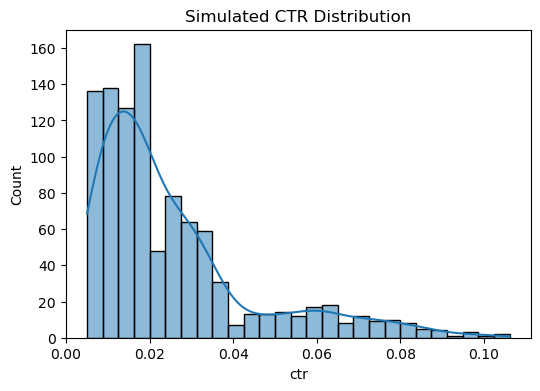

In [4]:
NUM_SAMPLES = 1000 # Number of dummy ad samples to create
IMAGE_DIR = './dummy_ad_images_projectP5/' # Directory to store dummy images

# Clean up old dummy images if they exist
if os.path.exists(IMAGE_DIR):
    shutil.rmtree(IMAGE_DIR)
os.makedirs(IMAGE_DIR)

data = {
    'ad_id': [],
    'image_path': [],
    'ad_text': [],
    'ctr': [] 
}

print(f"Generating {NUM_SAMPLES} dummy ad samples...")

# Try to get a basic font for drawing text on images
try:
    # This path might work on systems with common fonts, or use a specific .ttf path
    font = ImageFont.truetype("arial.ttf", 15) 
except IOError:
    font = ImageFont.load_default() # Fallback to default bitmap font
    print("Arial font not found, using default PIL font for dummy images.")

for i in range(NUM_SAMPLES):
    ad_id = f"ad_p5_{i:04d}"
    data['ad_id'].append(ad_id)
    
    # Create a dummy image with some variation
    img_path = os.path.join(IMAGE_DIR, f"{ad_id}.png")
    try:
        img_size = (128, 128)
        # Base color variation
        base_color = (np.random.randint(100, 256), np.random.randint(100, 256), np.random.randint(100, 256))
        img = Image.new('RGB', img_size, color = base_color)
        draw = ImageDraw.Draw(img)
        
        # Add some simple shapes or text to make images visually different
        if i % 3 == 0:
            draw.ellipse((20, 20, 60, 60), fill=(np.random.randint(0,100),0,0))
            draw.text((10, 70), "Sale!", fill=(255,255,0), font=font)
        elif i % 3 == 1:
            draw.rectangle((70, 30, 110, 70), fill=(0,np.random.randint(0,100),0))
            draw.text((10, 10), "New", fill=(0,0,255), font=font)
        else:
            draw.line((0,0) + img_size, fill=(np.random.randint(0,50),np.random.randint(0,50),np.random.randint(0,50)), width=5)
            draw.text((30, 50), ad_id[-2:], fill=(255,255,255), font=font)
            
        img.save(img_path)
        data['image_path'].append(img_path)
    except Exception as e:
        print(f"Could not create/save image {img_path}: {e}")
        data['image_path'].append(None)

    # Generate dummy ad text
    keywords_positive = ["amazing", "buy now", "limited offer", "exclusive", "best deal", "save big", "free shipping"]
    keywords_neutral = ["new product", "features", "quality design", "learn more", "discover", "check out", "easy to use"]
    keywords_generic = ["item", "service", "solution", "experience", "platform", "tool", "app"]
    
    text_parts = []
    # Simulate some structure in text for CTR correlation
    if i % 5 == 0: # Higher CTR ads
        text_parts.append(random.choice(keywords_positive))
        text_parts.append(random.choice(keywords_neutral))
        text_parts.append(random.choice(keywords_positive))
    elif i % 2 == 0: # Medium CTR ads
        text_parts.append(random.choice(keywords_neutral))
        text_parts.append(random.choice(keywords_generic))
        text_parts.append(random.choice(keywords_neutral))
    else: # Lower CTR ads
        text_parts.append(random.choice(keywords_generic))
        text_parts.append("for your needs")
        text_parts.append(random.choice(keywords_generic))
    
    data['ad_text'].append(" ".join(text_parts).capitalize() + ".")

    # Simulate CTR (more structured for better learning signal)
    sim_ctr = np.random.uniform(0.005, 0.02) # Base CTR (0.5% to 2%)
    current_text = data['ad_text'][-1].lower()
    if any(kw in current_text for kw in ["buy now", "limited offer", "exclusive", "save big"]):
        sim_ctr += np.random.uniform(0.02, 0.05)
    if "amazing" in current_text or "best deal" in current_text:
        sim_ctr += np.random.uniform(0.01, 0.03)
    if i % 3 == 0: # 'Sale!' image
        sim_ctr += np.random.uniform(0.01, 0.02)
        
    data['ctr'].append(min(max(sim_ctr, 0.001), 0.15)) # Ensure CTR is between 0.1% and 15%

df_ads = pd.DataFrame(data)
df_ads = df_ads.dropna(subset=['image_path']) # Remove samples where image creation might have failed

print(f"\nGenerated {len(df_ads)} dummy ad samples.")
print("\nFirst 5 rows of the dummy dataset:")
print(df_ads.head())

print("\nDataset Information:")
df_ads.info()

print("\nCTR Distribution (Simulated):")
print(df_ads['ctr'].describe())
plt.figure(figsize=(6,4))
sns.histplot(df_ads['ctr'], kde=True)
plt.title('Simulated CTR Distribution')
plt.show()

## Phase 2: Data Preprocessing & Feature Extraction

Now that we have our (simulated) data, we need to process the images and text to extract features that our deep learning model can use.

**Workflow:**
1.  **Image Preprocessing & Visual Feature Extraction:**
    * Load images.
    * Apply standard transformations (resize, normalize, convert to tensor) appropriate for the chosen pre-trained model.
    * Use a pre-trained Convolutional Neural Network (CNN) like ResNet50 or EfficientNet (from `timm`), or a Vision Transformer (ViT), to extract fixed-size feature vectors (embeddings). We'll typically use the output of a layer *before* the final classification layer of these pre-trained models.
2.  **Text Preprocessing & Textual Feature Extraction:**
    * Tokenize the ad text using a tokenizer compatible with our chosen pre-trained language model.
    * Use a pre-trained Transformer model (like BERT or Sentence-BERT from Hugging Face's `transformers` library) to get sentence or token-level embeddings. For simplicity in this project, we'll aim for a single vector representation for each ad text (e.g., the embedding of the `[CLS]` token for BERT, or mean-pooled output for Sentence-BERT).

In [5]:
# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Visual Feature Extraction ---
print("\nSetting up visual feature extractor...")
visual_model = None
image_transforms = None
VISUAL_FEATURE_DIM = 0 # Initialize

try:
    visual_model_name = 'efficientnet_b0' # A good balance of performance and size
    visual_model = timm.create_model(visual_model_name, pretrained=True, num_classes=0) # num_classes=0 removes classifier head
    visual_model.to(device)
    visual_model.eval() # Set to evaluation mode
    print(f"Loaded visual model: {visual_model_name}")

    # Get the required image transformations for the chosen model from timm's data_config
    data_config = timm.data.resolve_data_config({}, model=visual_model)
    image_transforms = timm.data.create_transform(**data_config)
    print("Image transforms for visual model (from timm):")
    print(image_transforms)
    
    # Determine visual feature dimension
    dummy_img_tensor = torch.randn(1, 3, data_config['input_size'][1], data_config['input_size'][2]).to(device)
    with torch.no_grad():
        dummy_vis_output = visual_model(dummy_img_tensor)
    VISUAL_FEATURE_DIM = dummy_vis_output.shape[-1]
    print(f"Visual feature dimension from {visual_model_name}: {VISUAL_FEATURE_DIM}")

except Exception as e:
    print(f"Error loading visual model with timm: {e}. Falling back to ResNet18 from torchvision.")
    visual_model = vision_models.resnet18(weights=vision_models.ResNet18_Weights.IMAGENET1K_V1)
    # Remove the final classification layer (fc) to get features
    visual_model = torch.nn.Sequential(*(list(visual_model.children())[:-1])) 
    visual_model.to(device)
    visual_model.eval()
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    print("Using fallback ResNet18 with standard transforms.")
    # Determine visual feature dimension for ResNet18 (output of avgpool is 512 for resnet18)
    VISUAL_FEATURE_DIM = 512 
    print(f"Visual feature dimension for ResNet18: {VISUAL_FEATURE_DIM}")

def extract_visual_features(image_path, model, transform, expected_dim):
    if image_path is None or not os.path.exists(image_path):
        # print(f"Warning: Image not found or path is None: {image_path}. Returning zero vector.")
        return np.zeros(expected_dim, dtype=np.float32)
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device) 
        with torch.no_grad():
            features = model(img_tensor)
        # For models like ResNet where we remove fc, output is (batch, features, 1, 1). Need to flatten.
        # For timm models with num_classes=0, output is usually (batch, features).
        if features.ndim > 2:
            features = features.squeeze(-1).squeeze(-1) # Remove trailing 1x1 dimensions if they exist
        return features.squeeze(0).cpu().numpy() # Remove batch dim, move to CPU, convert to numpy
    except Exception as e:
        print(f"Error processing image {image_path}: {e}. Returning zero vector.")
        return np.zeros(expected_dim, dtype=np.float32)

# --- 2. Textual Feature Extraction ---
print("\nSetting up textual feature extractor...")
text_tokenizer = None
text_model = None
TEXTUAL_FEATURE_DIM = 0 # Initialize

try:
    text_model_name = 'sentence-transformers/all-MiniLM-L6-v2' 
    text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
    text_model = AutoModel.from_pretrained(text_model_name)
    text_model.to(device)
    text_model.eval()
    print(f"Loaded text model: {text_model_name}")
    TEXTUAL_FEATURE_DIM = text_model.config.hidden_size # For sentence-transformers, this is usually the embedding dim
    print(f"Textual feature dimension from {text_model_name}: {TEXTUAL_FEATURE_DIM}")
except Exception as e:
    print(f"Could not load text model '{text_model_name}' due to: {e}.")
    print("Ensure you have an internet connection or the model is cached. Text features will be zeros.")
    TEXTUAL_FEATURE_DIM = 384 # Fallback dimension if model load fails, common for MiniLM

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def extract_textual_features(text, tokenizer, model, expected_dim):
    if text is None or tokenizer is None or model is None:
        return np.zeros(expected_dim, dtype=np.float32)
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # Perform pooling. For sentence-transformers, mean pooling is standard.
        sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
        return sentence_embedding.squeeze().cpu().numpy()
    except Exception as e:
        print(f"Error processing text '{text[:30]}...': {e}. Returning zero vector.")
        return np.zeros(expected_dim, dtype=np.float32)

# Apply feature extraction to our dummy DataFrame
if 'df_ads' in locals() and not df_ads.empty and visual_model is not None and text_model is not None and image_transforms is not None:
    print("\nExtracting visual features for all ads...")
    # Make sure VISUAL_FEATURE_DIM is correctly determined before this loop
    if VISUAL_FEATURE_DIM == 0:
        print("Error: VISUAL_FEATURE_DIM is 0. Cannot extract visual features.")
    else:
        df_ads['visual_features'] = df_ads['image_path'].apply(lambda x: extract_visual_features(x, visual_model, image_transforms, VISUAL_FEATURE_DIM))
    
    print("\nExtracting textual features for all ads...")
    if TEXTUAL_FEATURE_DIM == 0:
        print("Error: TEXTUAL_FEATURE_DIM is 0. Cannot extract textual features.")
    else:
        df_ads['textual_features'] = df_ads['ad_text'].apply(lambda x: extract_textual_features(x, text_tokenizer, text_model, TEXTUAL_FEATURE_DIM))

    print("\nFirst 5 rows with extracted features (or attempted extraction):")
    print(df_ads[['ad_id', 'visual_features', 'textual_features', 'ctr']].head())
    
    if not df_ads.empty and 'visual_features' in df_ads.columns and df_ads['visual_features'].iloc[0] is not None:
        print(f"Shape of visual features for one sample: {df_ads['visual_features'].iloc[0].shape}")
    if not df_ads.empty and 'textual_features' in df_ads.columns and df_ads['textual_features'].iloc[0] is not None:
        print(f"Shape of textual features for one sample: {df_ads['textual_features'].iloc[0].shape}")
else:
    print("\nSkipping feature extraction as DataFrame, models, or transforms are not available/initialized.")

Using device: cuda

Setting up visual feature extractor...
Loaded visual model: efficientnet_b0
Image transforms for visual model (from timm):
Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Visual feature dimension from efficientnet_b0: 1280

Setting up textual feature extractor...


c:\Users\amanp\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded text model: sentence-transformers/all-MiniLM-L6-v2
Textual feature dimension from sentence-transformers/all-MiniLM-L6-v2: 384

Extracting visual features for all ads...

Extracting textual features for all ads...

First 5 rows with extracted features (or attempted extraction):
        ad_id                                    visual_features  \
0  ad_p5_0000  [-0.1595473, -0.134001, -0.1652148, -0.0556688...   
1  ad_p5_0001  [0.11280519, -0.085349046, -0.13633345, -0.046...   
2  ad_p5_0002  [-0.19935529, -0.11644123, -0.14044398, -0.181...   
3  ad_p5_0003  [-0.19024108, -0.1979075, -0.1840106, -0.06556...   
4  ad_p5_0004  [0.29554537, -0.1160732, -0.16087067, -0.06604...   

                                    textual_features       ctr  
0  [-0.14314634, 0.13981734, 0.26647672, -0.27117...  0.062361  
1  [-0.14481695, 0.12230199, -0.416777, -0.211952...  0.014763  
2  [-0.2314481, -0.06863465, 0.42056048, -0.20860...  0.005012  
3  [-0.23426881, 0.14431398, -0.30669576, 0.03

## Phase 3: Model Architecture (Multi-Modal Fusion)

Now that I have visual and textual features, I need to design a model that can combine (fuse) them and make a prediction.

**Common Fusion Strategies:**

1.  **Early Fusion (Concatenation):** Simply concatenate the visual and textual feature vectors. This combined vector is then fed into one or more fully connected (dense) layers for prediction.
2.  **Late Fusion:** Train separate models/towers for each modality up to a certain point, then combine their outputs (e.g., averaging predictions, or concatenating higher-level representations).
3.  **Attention-based Fusion (e.g., Cross-Attention):** More sophisticated methods where one modality can 'attend' to parts of the other modality to learn weighted combinations. This can capture more complex inter-modal relationships.

For this project, I'll start with **Early Fusion (Concatenation)** because it's straightforward to implement and often provides a good baseline.

**Model Structure:**
* Input: Visual feature vector, Textual feature vector.
* Concatenate these two vectors.
* Pass the concatenated vector through a few Dense layers (with activations like ReLU and Dropout for regularization).
* Output Layer: A single neuron with a linear activation (if predicting CTR directly as a regression task). If CTR values were strictly bounded (e.g., 0-1 after scaling) and a sigmoid was desired, we could add that, but for MSE loss, a linear output is standard.

In [6]:
class MultiModalAdPerformancePredictor(nn.Module):
    def __init__(self, visual_feature_dim, textual_feature_dim, hidden_dims=[256, 128], dropout_p=0.3):
        super(MultiModalAdPerformancePredictor, self).__init__()
        
        if visual_feature_dim <= 0 or textual_feature_dim <= 0:
            raise ValueError("Feature dimensions must be positive.")
            
        self.visual_feature_dim = visual_feature_dim
        self.textual_feature_dim = textual_feature_dim
        self.combined_feature_dim = visual_feature_dim + textual_feature_dim
        
        layers = []
        input_dim = self.combined_feature_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h_dim)) # Added BatchNorm
            layers.append(nn.Dropout(dropout_p))
            input_dim = h_dim
            
        self.fusion_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(input_dim, 1) # Output 1 value for CTR

    def forward(self, visual_features, textual_features):
        combined_features = torch.cat((visual_features, textual_features), dim=1)
        x = self.fusion_layers(combined_features)
        output = self.output_layer(x)
        # For MSE loss, we typically don't apply a final sigmoid if the target isn't scaled to 0-1.
        # If targets were scaled 0-1, you might add: output = torch.sigmoid(output)
        return output

fusion_model = None # Initialize
if 'VISUAL_FEATURE_DIM' in locals() and 'TEXTUAL_FEATURE_DIM' in locals() and VISUAL_FEATURE_DIM > 0 and TEXTUAL_FEATURE_DIM > 0:
    print(f"\nInitializing MultiModalAdPerformancePredictor with:")
    print(f"  Visual Feature Dim: {VISUAL_FEATURE_DIM}")
    print(f"  Textual Feature Dim: {TEXTUAL_FEATURE_DIM}")
    
    fusion_model = MultiModalAdPerformancePredictor(VISUAL_FEATURE_DIM, TEXTUAL_FEATURE_DIM, hidden_dims=[512, 256, 128], dropout_p=0.4)
    fusion_model.to(device)
    print("\nMulti-Modal Fusion Model Architecture:")
    print(fusion_model)

    # Sanity check with dummy features
    dummy_batch_size = 4
    dummy_vis_feat = torch.randn(dummy_batch_size, VISUAL_FEATURE_DIM).to(device)
    dummy_txt_feat = torch.randn(dummy_batch_size, TEXTUAL_FEATURE_DIM).to(device)
    with torch.no_grad():
        fusion_model.eval()
        dummy_output = fusion_model(dummy_vis_feat, dummy_txt_feat)
        fusion_model.train()
    print(f"\nDummy output shape from fusion model: {dummy_output.shape}")
    assert dummy_output.shape == (dummy_batch_size, 1)
    print("Fusion model sanity check passed.")
else:
    print("Error: VISUAL_FEATURE_DIM or TEXTUAL_FEATURE_DIM not properly defined from feature extraction phase. Skipping fusion model instantiation.")


Initializing MultiModalAdPerformancePredictor with:
  Visual Feature Dim: 1280
  Textual Feature Dim: 384

Multi-Modal Fusion Model Architecture:
MultiModalAdPerformancePredictor(
  (fusion_layers): Sequential(
    (0): Linear(in_features=1664, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

Dummy output shape from fusion model: torch.Size([4, 1])
Fusion model sanity check passe

## Phase 4: Model Training

Now I'll set up the training loop for our multi-modal fusion model.

1.  **Prepare Data for PyTorch:** Create a custom `Dataset` and `DataLoader`.
2.  **Loss Function:** Since we're predicting CTR (a continuous value), Mean Squared Error (`nn.MSELoss`) is a common choice for regression.
3.  **Optimizer:** Adam is a good default.
4.  **Training Loop:** Iterate through epochs and batches, calculate loss, backpropagate, and update weights.
5.  **Validation:** Evaluate on a validation set to monitor performance and prevent overfitting.

Training samples: 700
Validation samples: 150
Test samples: 150
Created DataLoaders for ads.

Starting Ad Performance Model Training for 30 epochs...
Epoch [1/30] - Training Loss: 0.454204
Epoch [1/30] - Validation Loss: 0.013077
Epoch [2/30] - Training Loss: 0.291074
Epoch [2/30] - Validation Loss: 0.044919
Epoch [3/30] - Training Loss: 0.239270
Epoch [3/30] - Validation Loss: 0.013543
Epoch [4/30] - Training Loss: 0.175413
Epoch [4/30] - Validation Loss: 0.012714
Epoch [5/30] - Training Loss: 0.150844
Epoch [5/30] - Validation Loss: 0.014026
Epoch [6/30] - Training Loss: 0.139907
Epoch [6/30] - Validation Loss: 0.005505
Epoch [7/30] - Training Loss: 0.120254
Epoch [7/30] - Validation Loss: 0.007024
Epoch [8/30] - Training Loss: 0.100479
Epoch [8/30] - Validation Loss: 0.008727
Epoch [9/30] - Training Loss: 0.076978
Epoch [9/30] - Validation Loss: 0.002731
Epoch [10/30] - Training Loss: 0.072125
Epoch [10/30] - Validation Loss: 0.002012
Epoch [11/30] - Training Loss: 0.061992
Epoch [1

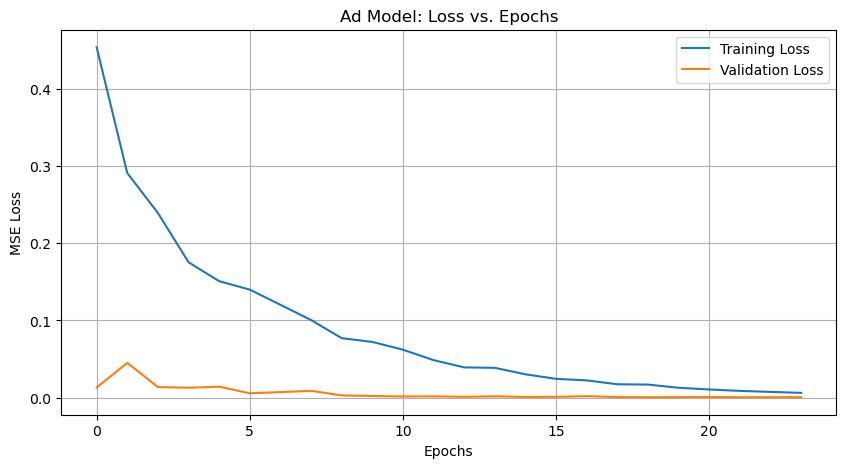

In [7]:
class AdDataset(Dataset):
    def __init__(self, dataframe, vis_feat_col='visual_features', txt_feat_col='textual_features', target_col='ctr'):
        # Filter out rows where features might be None (e.g., if extraction failed for some)
        self.dataframe = dataframe.dropna(subset=[vis_feat_col, txt_feat_col, target_col])
        
        # It's crucial that all feature vectors have the same dimension.
        # Stacking will fail if there are inconsistencies (e.g. some are None or different shapes).
        self.visual_features = np.stack(self.dataframe[vis_feat_col].values).astype(np.float32)
        self.textual_features = np.stack(self.dataframe[txt_feat_col].values).astype(np.float32)
        self.targets = self.dataframe[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'visual': torch.tensor(self.visual_features[idx], dtype=torch.float),
            'textual': torch.tensor(self.textual_features[idx], dtype=torch.float),
            'target': torch.tensor(self.targets[idx], dtype=torch.float).unsqueeze(0) # Ensure target is [1] for MSELoss
        }

train_ad_loader, val_ad_loader, test_ad_loader = None, None, None
BATCH_SIZE_ADS = 32 # Define batch size for ads dataset

if 'df_ads' in locals() and not df_ads.empty and \
   'visual_features' in df_ads.columns and df_ads['visual_features'].notna().all() and \
   'textual_features' in df_ads.columns and df_ads['textual_features'].notna().all():
    
    # Ensure all feature vectors are indeed numpy arrays of consistent shape before creating AdDataset
    if not all(isinstance(x, np.ndarray) and x.shape == df_ads['visual_features'].iloc[0].shape for x in df_ads['visual_features']):
        print("Error: Inconsistent visual feature shapes or types.")
    elif not all(isinstance(x, np.ndarray) and x.shape == df_ads['textual_features'].iloc[0].shape for x in df_ads['textual_features']):
        print("Error: Inconsistent textual feature shapes or types.")
    else:
        df_train_val, df_test = train_test_split(df_ads, test_size=0.15, random_state=SEED)
        df_train, df_val = train_test_split(df_train_val, test_size=0.15 / 0.85, random_state=SEED) # 0.15 of original for val

        print(f"Training samples: {len(df_train)}")
        print(f"Validation samples: {len(df_val)}")
        print(f"Test samples: {len(df_test)}")

        if not df_train.empty:
            train_ad_dataset = AdDataset(df_train)
            train_ad_loader = DataLoader(train_ad_dataset, batch_size=BATCH_SIZE_ADS, shuffle=True)
        if not df_val.empty:
            val_ad_dataset = AdDataset(df_val)
            val_ad_loader = DataLoader(val_ad_dataset, batch_size=BATCH_SIZE_ADS, shuffle=False)
        if not df_test.empty:
            test_ad_dataset = AdDataset(df_test)
            test_ad_loader = DataLoader(test_ad_dataset, batch_size=BATCH_SIZE_ADS, shuffle=False)
        print("Created DataLoaders for ads.")

        if fusion_model is not None and train_ad_loader is not None:
            criterion_ads = nn.MSELoss()
            optimizer_ads = torch.optim.Adam(fusion_model.parameters(), lr=0.0005, weight_decay=1e-5)
            NUM_EPOCHS_ADS = 30 # Increased epochs, added weight decay

            print(f"\nStarting Ad Performance Model Training for {NUM_EPOCHS_ADS} epochs...")
            train_loss_hist_ads, val_loss_hist_ads = [], []
            best_val_loss_ads = float('inf')
            epochs_no_improve_ads = 0
            patience_ads = 5

            for epoch in range(NUM_EPOCHS_ADS):
                fusion_model.train()
                running_train_loss = 0.0
                for batch in train_ad_loader:
                    vis_feat, txt_feat, targets = batch['visual'].to(device), batch['textual'].to(device), batch['target'].to(device)
                    optimizer_ads.zero_grad()
                    predictions = fusion_model(vis_feat, txt_feat)
                    loss = criterion_ads(predictions, targets)
                    loss.backward()
                    optimizer_ads.step()
                    running_train_loss += loss.item() * vis_feat.size(0)
                epoch_train_loss = running_train_loss / len(train_ad_loader.dataset)
                train_loss_hist_ads.append(epoch_train_loss)
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS_ADS}] - Training Loss: {epoch_train_loss:.6f}")

                if val_ad_loader is not None:
                    fusion_model.eval()
                    running_val_loss = 0.0
                    with torch.no_grad():
                        for batch in val_ad_loader:
                            vis_feat, txt_feat, targets = batch['visual'].to(device), batch['textual'].to(device), batch['target'].to(device)
                            predictions = fusion_model(vis_feat, txt_feat)
                            loss = criterion_ads(predictions, targets)
                            running_val_loss += loss.item() * vis_feat.size(0)
                    epoch_val_loss = running_val_loss / len(val_ad_loader.dataset)
                    val_loss_hist_ads.append(epoch_val_loss)
                    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_ADS}] - Validation Loss: {epoch_val_loss:.6f}")
                    if epoch_val_loss < best_val_loss_ads:
                        best_val_loss_ads = epoch_val_loss
                        epochs_no_improve_ads = 0
                        # torch.save(fusion_model.state_dict(), 'best_fusion_model.pth') # Optional: save best model
                    else:
                        epochs_no_improve_ads += 1
                    if epochs_no_improve_ads >= patience_ads:
                        print(f"Early stopping triggered at epoch {epoch+1}.")
                        break
                else:
                    val_loss_hist_ads.append(float('nan'))
            print("\nAd Performance Model Training Finished.")
            
            plt.figure(figsize=(10, 5))
            plt.plot(train_loss_hist_ads, label='Training Loss')
            if any(not np.isnan(x) for x in val_loss_hist_ads): plt.plot(val_loss_hist_ads, label='Validation Loss')
            plt.title('Ad Model: Loss vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('MSE Loss'); plt.legend(); plt.grid(True)
            plt.show()
        else:
            print("Fusion model not available or train_ad_loader not created. Skipping training.")
else:
    print("\nDataFrame 'df_ads' not populated or features not properly extracted (e.g., contains NaNs or inconsistent shapes). Skipping training setup.")

## Phase 5: Evaluation

For our CTR prediction task (regression), common evaluation metrics include:

* **Mean Squared Error (MSE):** Average of the squares of the errors between predicted and actual CTR.
* **Root Mean Squared Error (RMSE):** Square root of MSE, giving an error in the same units as CTR.
* **Mean Absolute Error (MAE):** Average of the absolute differences between predicted and actual CTR.

If we were doing classification (e.g., predict high/low CTR bucket), we'd use metrics like Accuracy, Precision, Recall, F1-score, and AUC-ROC.


--- Ad Performance Model Evaluation on Test Set ---
Mean Squared Error (MSE): 0.000243
Root Mean Squared Error (RMSE): 0.015583
Mean Absolute Error (MAE): 0.011167


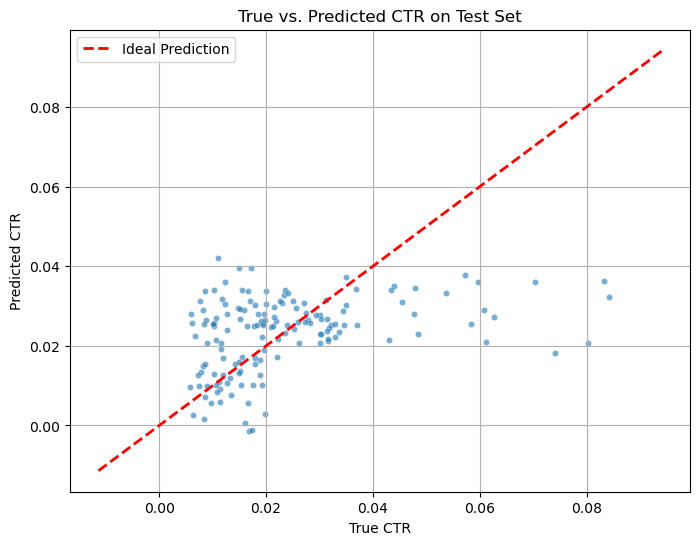

In [8]:
if 'fusion_model' in locals() and fusion_model is not None and 'test_ad_loader' in locals() and test_ad_loader is not None and len(test_ad_loader) > 0:
    fusion_model.eval()
    all_targets_list = []
    all_predictions_list = []

    with torch.no_grad():
        for batch in test_ad_loader:
            vis_feat = batch['visual'].to(device)
            txt_feat = batch['textual'].to(device)
            targets = batch['target'] 
            predictions = fusion_model(vis_feat, txt_feat)
            all_targets_list.extend(targets.squeeze().cpu().numpy().tolist())
            all_predictions_list.extend(predictions.squeeze().cpu().numpy().tolist())

    if all_targets_list and all_predictions_list:
        all_targets_np = np.array(all_targets_list)
        all_predictions_np = np.array(all_predictions_list)

        mse = mean_squared_error(all_targets_np, all_predictions_np)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(all_targets_np, all_predictions_np)

        print("\n--- Ad Performance Model Evaluation on Test Set ---")
        print(f"Mean Squared Error (MSE): {mse:.6f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"Mean Absolute Error (MAE): {mae:.6f}")
        
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=all_targets_np, y=all_predictions_np, alpha=0.6, s=20)
        # Ideal line (y=x)
        min_val = 0
        if len(all_targets_np) > 0 and len(all_predictions_np) > 0:
            min_val = min(all_targets_np.min(), all_predictions_np.min()) - 0.01
        max_val = 0.16 # Based on simulated CTR cap
        if len(all_targets_np) > 0 and len(all_predictions_np) > 0:
            max_val = max(all_targets_np.max(), all_predictions_np.max()) + 0.01
        
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction')
        plt.xlabel("True CTR")
        plt.ylabel("Predicted CTR")
        plt.title("True vs. Predicted CTR on Test Set")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No predictions or targets collected for evaluation from test set.")
else:
    print("\nFusion model or test data loader not available/empty. Skipping evaluation.")

## Phase 6: Further Steps & Iteration

This project provides a strong foundation for multi-modal ad performance prediction. Here are some ways I could extend or improve it:

1.  **Real Dataset:** The most crucial step would be to acquire and use a real-world dataset of ad creatives with actual performance metrics.
2.  **Video Ads:** Extend to video by:
    * Extracting representative frames (e.g., using techniques like keyframe extraction or sampling frames at regular intervals).
    * Averaging frame features or using an RNN/Transformer to process sequences of frame features.
    * Exploring 3D CNNs or Video Transformers designed specifically for video input.
3.  **More Sophisticated Fusion:**
    * **Cross-Modal Attention:** Allow visual features to attend to textual features and vice-versa before final fusion. This can help the model learn which parts of one modality are most relevant given the other.
    * **Gated Mechanisms:** Use gates to control the flow of information from each modality into the fused representation.
    * **Transformer-based Fusion:** Employ Transformer layers for fusing the concatenated features or for cross-modal attention.
4.  **Hyperparameter Tuning:** Systematically tune learning rates, hidden dimensions, dropout rates, network architecture, etc., using techniques like grid search, random search, or Bayesian optimization (e.g., with Optuna).
5.  **Advanced Pre-trained Models:** Experiment with larger or more specialized pre-trained models for vision (e.g., ViT variants, larger EfficientNets) and text (e.g., RoBERTa, DeBERTa).
6.  **Target Engineering:** 
    * Instead of raw CTR, predict log(CTR) or use a loss function more suited for skewed distributions if CTRs are very low (e.g., Poisson loss, Tweedie loss).
    * Consider quantile regression if predicting a range of CTRs is important.
    * Frame as a classification problem (e.g., high/medium/low CTR) if precise regression is too difficult or not needed, and use appropriate classification metrics.
7.  **Interpreting the Model:** Use techniques like SHAP or LIME, or analyze attention weights (if using attention-based fusion), to understand which features (visual or textual) are most influential in the model's predictions.
8.  **Handling Other Ad Components:** Incorporate features from advertiser information, targeting parameters, ad format, landing page content, etc., if available.

This multi-modal field is rich with possibilities!

## Project Conclusion

In this project, I've outlined and implemented a pipeline for predicting ad creative performance using multi-modal deep learning, albeit with simulated data to enable end-to-end development. We covered:

* Feature extraction from images using pre-trained CV models (`timm`).
* Feature extraction from text using pre-trained NLP models (`transformers`).
* A multi-modal fusion architecture (concatenation followed by dense layers with batch normalization and dropout).
* A training loop for a regression task (predicting CTR) using MSE loss, including validation and basic early stopping.
* Standard regression evaluation metrics (MSE, RMSE, MAE) and visualization.
* Numerous avenues for future improvements and more advanced implementations.

Building this system, even with simulated data, provides a strong understanding of the components involved in tackling complex multi-modal machine learning problems. The real challenge often lies in curating a high-quality, labeled dataset, but the modeling techniques explored here are foundational for analyzing and predicting the performance of rich media content.